In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from stefcal_uvdata import StefcalUVData
import stefcal_uvdata as suv
from data import DATA_PATH
import matplotlib.pyplot as plt

In this notebook, we test multi-frequency calibration with a model of the VLA. The model is 200 channels between 100 and 200 MHz with a single 100 Jy point source at zenith. First we check the noise properties of multi-frequency calibration with unity gains. 

In [2]:
#initialize stefcal object 
stefcal_perfect=StefcalUVData()
complete_vis_path=os.path.join(DATA_PATH,
                               'point_source_sim_mfs_20chan.noisy.uvfits')
incomplete_vis_path=os.path.join(DATA_PATH,
                                 'point_source_sim_mfs_20chan.uvfits')
#read in uvfits data and model files
stefcal_perfect.from_uvfits(complete_vis_path,incomplete_vis_path,
                           flag_weights_fromdata=True)
#set calibration parameters
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':1,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':1})      


Telescope VLA is not in known_telescopes.


In [3]:
stefcal_perfect.stefcalibrate()

boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 1


Lets test whether the standard deviation of the gains agrees with the theoretical prediction.
\begin{equation}
\sigma_g=\frac{\sigma_N}{S_0}\frac{1}{\sqrt{N_t(N_{ant}-1)}}
\end{equation}
where $S_0=100$Jy

100.0
0.00540614988667
0.00588219404869
-8.8-percent difference in estimated noises


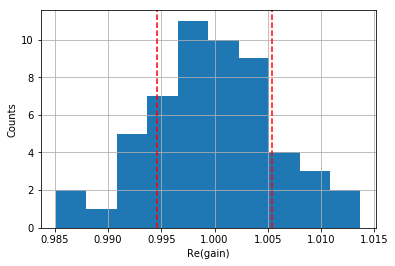

In [4]:
chan=-1
plt.hist(np.real(stefcal_perfect.uvcal.gain_array[:,0,chan,:].flatten()),bins=10)
rms_vis=np.sqrt(np.mean(np.abs(stefcal_perfect.model_vis.data_array[:,0,chan,:].flatten()**2.)))
print rms_vis
plt.xlabel('Re(gain)')
plt.ylabel('Counts')
plt.grid()
std_est=np.sqrt(stefcal_perfect.meta_params.noise_tblavg[chan]/2.)
gain_std_est=std_est/np.sqrt(stefcal_perfect.uvcal.Nants_data-1.)/rms_vis
print gain_std_est
gain_std_re=np.std(np.real(stefcal_perfect.uvcal.gain_array[:,0,chan,:].flatten()))
gain_std_im=np.std(np.real(stefcal_perfect.uvcal.gain_array[:,0,chan,:].flatten()))
print gain_std_re
print('%.1f-percent difference in estimated noises'%(100.*(1.-gain_std_re/gain_std_est)))
plt.axvline(1-gain_std_est,color='r',ls='--')
plt.axvline(1+gain_std_est,color='r',ls='--')

Now we try calibrating noiseless data with simulated gains. 

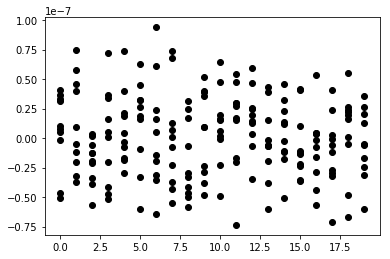

In [6]:
#initialize stefcal object 
stefcal_perfect=StefcalUVData()
complete_vis_path=os.path.join(DATA_PATH,
                               'point_source_sim_mfs_20chan.noisy.uvfits')
incomplete_vis_path=os.path.join(DATA_PATH,
                                 'point_source_sim_mfs_20chan.uvfits')
#read in uvfits data and model files
stefcal_perfect.from_uvfits(incomplete_vis_path,incomplete_vis_path,
                           flag_weights_fromdata=True)
#set calibration parameters
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':3,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':1})      


#run calibration
#stefcal_perfect.stefcalibrate()
freqs=stefcal_perfect.measured_vis.freq_array
gains=np.ones((27,1,20,1,2),dtype=complex)
mean_amp=1e-1
std_amp=1e-2
amps=np.abs(np.random.randn(27,2)*std_amp+mean_amp)
mean_delay=200e-9
std_delay=10e-9
delays=np.abs(np.random.randn(27,2)*std_delay+mean_delay)
phases=np.random.rand(27,2)
for pol in range(2):
    for ant in range(27):
        d=delays[ant,pol].squeeze()
        a=amps[ant,pol].squeeze()
        p=phases[ant,pol].squeeze()
        gains[ant,0,:,0,pol]=(1./(1.+a*np.exp(2j*np.pi*(freqs*d+p))))
#set the reference antenna phases to zero!
gains[0,0,:,0,:]=np.abs(gains[0,0,:,0,:])
test_gains=stefcal_perfect.uvcal_from_data()
test_gains.gain_array=gains
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains,applyGains=True)
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':10,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':1})      
stefcal_perfect.stefcalibrate()
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains)
gains_estimated=stefcal_perfect.uvcal.gain_array
pol=1
for ant in range(10):
    plt.plot(np.real(gains_estimated[ant,0,:,0,pol]-gains[ant,0,:,0,pol]),color='k',marker='o',ls='none')






and now simulated data with noise. 

In [21]:
#initialize stefcal object 
stefcal_perfect=StefcalUVData()
complete_vis_path=os.path.join(DATA_PATH,
                               'point_source_sim_mfs_20chan.noisy.uvfits')
incomplete_vis_path=os.path.join(DATA_PATH,
                                 'point_source_sim_mfs_20chan.uvfits')
#read in uvfits data and model files
stefcal_perfect.from_uvfits(complete_vis_path,incomplete_vis_path,
                           flag_weights_fromdata=True)
#set calibration parameters
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':3,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':1})      


#run calibration
#stefcal_perfect.stefcalibrate()
freqs=stefcal_perfect.measured_vis.freq_array
gains=np.ones((27,1,20,1,2),dtype=complex)
mean_amp=1e-1
std_amp=1e-2
amps=np.abs(np.random.randn(27,2)*std_amp+mean_amp)
mean_delay=200e-9
std_delay=10e-9
delays=np.abs(np.random.randn(27,2)*std_delay+mean_delay)
phases=np.random.rand(27,2)
for pol in range(2):
    for ant in range(27):
        d=delays[ant,pol].squeeze()
        a=amps[ant,pol].squeeze()
        p=phases[ant,pol].squeeze()
        gains[ant,0,:,0,pol]=(1./(1.+a*np.exp(2j*np.pi*(freqs*d+p))))
#set the reference antenna phases to zero!
gains[0,0,:,0,:]=np.abs(test_gains.gain_array[0,0,:,0,:])
test_gains=stefcal_perfect.uvcal_from_data()
test_gains.gain_array=gains
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains,applyGains=True)
stefcal_perfect.set_params({'trim_neff':False,
                           'min_ant_times':1,
                           'eps':1e-10,
                           'min_bl_per_ant':2,
                           'n_cycles':10,
                           'n_phase_iter':0,
                           'refant':0,
                           't_avg':1})      
stefcal_perfect.stefcalibrate()
stefcal_perfect.measured_vis=suv.correct_vis(stefcal_perfect.measured_vis,test_gains)
gains_estimated=stefcal_perfect.uvcal.gain_array
pol=1





In [ ]:
We find that with the point sourc emo

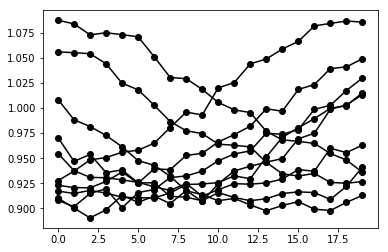

100.0
0.00558714666732
0.00582848471586
-4.3-percent difference in estimated noises


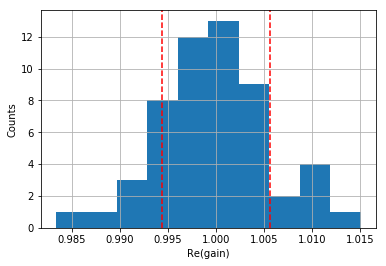

In [22]:

for ant in range(10):
    plt.plot(np.real(gains_estimated[ant,0,:,0,pol]),color='k',marker='o',ls='-')
plt.show()
chan=-1
plt.hist(1.+np.real((stefcal_perfect.uvcal.gain_array[:,0,chan,:]\
                     -test_gains.gain_array[:,0,chan,:]).flatten()),bins=10)
rms_vis=np.sqrt(np.mean(np.abs(stefcal_perfect.model_vis.data_array[:,0,chan,:].flatten()**2.)))
print rms_vis
plt.xlabel('Re(gain)')
plt.ylabel('Counts')
plt.grid()
std_est=np.sqrt(stefcal_perfect.meta_params.noise_tblavg[chan]/2.)
gain_std_est=std_est/np.sqrt(stefcal_perfect.uvcal.Nants_data-1.)/rms_vis
print gain_std_est
gain_std_re=np.std(np.real(stefcal_perfect.uvcal.gain_array[:,0,chan,:]-\
                           test_gains.gain_array[:,0,chan,:]).flatten())

gain_std_im=np.std(np.imag(stefcal_perfect.uvcal.gain_array[:,0,chan,:]-\
                           test_gains.gain_array[:,0,chan,:]).flatten())
print gain_std_re
print('%.1f-percent difference in estimated noises'%(100.*(1.-gain_std_re/gain_std_est)))
plt.axvline(1-gain_std_est,color='r',ls='--')
plt.axvline(1+gain_std_est,color='r',ls='--')